In [1]:
import os, statistics, textwrap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter

output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Load the spreadsheet
file_path = "llm_patients_043025.csv"
df = pd.read_csv(file_path, delimiter="|")

# Use a smoothing function to handle low-overlap n-gram cases
smoothing_fn = SmoothingFunction().method1

# Define relevant columns
llm_columns = [
    "Children Details", "Family History of Health Conditions Details", "Sibling Details",
    "Previous Work History", "Previous Marriages/Long-Term Relationships",
    "Hobbies", "Relaxation Methods", "Rehab or Substance Counselling",
    "Previous Hospitalizations or Surgeries Details", "Head Injuries or Concussions Details",
    "Disability Details", "Disability Assistance Details"
]

llm_columns_abbr = [
    "Children Details", "Family Health Hx Details", "Sibling Details",
    "Work Hx", "Past Marriages/Relationships", "Hobbies", "Relaxation Methods", 
    "Substance Rehab/Counselling", "Hosp./Surgeries Details", "Head Injuries/Concussions Details",
    "Disability Details", "Disability Assistance Details"
]


# Define function to wrap labels
def wrap_labels(labels, width=20):
    return [textwrap.fill(label, width) for label in labels]

def plot_graphs(df_index, df_, ylabel, title, savefig=True):
    plt.figure(figsize=(10, 5))
    plt.bar(df_index, df_, color='blue')
    # Wrap x-tick labels for better readability
    wrapped_labels = wrap_labels(df_index)
    plt.xticks(ticks=range(len(df_index)), labels=wrapped_labels, rotation=90)
    plt.ylabel(ylabel)
    plt.title(title)
    if savefig:
        filename = f"{output_dir}/{title.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

def plot_graphs_std(df_index, df_, std, ylabel, title, savefig=True):
    plt.figure(figsize=(10, 5))
    plt.bar(df_index, df_, color='blue', yerr=std, capsize=5)
    # Wrap x-tick labels
    wrapped_labels = wrap_labels(df_index)
    plt.xticks(ticks=range(len(df_index)), labels=wrapped_labels, rotation=90)
    plt.ylabel(ylabel)
    plt.title(title)
    if savefig:
        filename = f"{output_dir}/{title.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

In [2]:
def bootstrap_sample(data, llm_columns, n_samples=1000, sample_size=None):
    """
    Perform bootstrapping on a dataset and apply three metrics separately for each column.
    
    Parameters:
        data (pd.DataFrame): The dataset to bootstrap.
        llm_columns (list): List of column names to evaluate.
        n_samples (int): Number of bootstrap samples to generate.
        sample_size (int, optional): Size of each bootstrap sample (default is size of original dataset).
    
    Returns:
        dict: Bootstrap results containing metrics for each column separately.
    """
    if sample_size is None:
        sample_size = len(data)

    # Store results separately for each column
    results = {col: {"dup_ratio": [], "distinct_1": [], "global_dis_1": []} for col in llm_columns}

    ## Column: Children Details:
    ##         "dup_ratio": [x, x1, x2... x1000],
    ##          ""
    ## ...
    ## Column: 
    i = 0
    for _ in range(n_samples):
        i += 1
        # print(i)
        sample = data.sample(n=sample_size, replace=True)

        for col in llm_columns: 
            non_empty_entries = sample[col].dropna() # list or df
            unique_count = non_empty_entries.nunique() # number
            duplicate_count = len(non_empty_entries) - unique_count  # Total - unique = int

            # Compute metrics
            # bleu_score = compute_self_bleu_optimized(sample[col])
            dup_ratio = duplicate_count / len(non_empty_entries) if len(non_empty_entries) > 0 else 0
            distinct_1_score = compute_distinct_ngram_ratio(non_empty_entries, n=1)
            global_distinct_1 = compute_global_distinct_n(non_empty_entries, n=1)

            # Store results
            # results[col]["self_bleu"].append(bleu_score)
            results[col]["dup_ratio"].append(dup_ratio)
            results[col]["distinct_1"].append(distinct_1_score)
            results[col]["global_dis_1"].append(global_distinct_1)

    return results

def compute_distinct_ngram_ratio(text_series, n=1):
    """Computes the distinct-n ratio (Distinct-1 for unigrams, Distinct-2 for bigrams)"""
    all_scores = []
    for text in text_series.dropna():
        words = text.lower().split()
        # ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
        total_words = len(words)
        unique_words = len(set(words))
        if total_words > 0:
            distinct_1_score = unique_words/total_words
        else:
            distinct_1_score = 0
        all_scores.append(distinct_1_score)
    
    average = statistics.fmean(all_scores)
    return average

def compute_global_distinct_n(text_series, n=1):
    """
    Computes the fraction of all n-grams in `text_series` that are unique
    (i.e. |set(ngrams)| / total # of ngrams).
    """
    all_ngrams = []
    for text in text_series.dropna():
        words = text.lower().split()
        all_ngrams += [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    if not all_ngrams:
        return 0.0
    return len(set(all_ngrams)) / len(all_ngrams)

def compute_batch_global_distinct_n(df, columns, n=1):
    """
    Computes distinct-n over the concatenation of text in `columns`.
    (i.e. |set(all n-grams)| / total # of n-grams).
    """
    all_ngrams = []
    for col in columns:
        for text in df[col].dropna():
            words = text.lower().split()
            all_ngrams += [
                ' '.join(words[i:i+n])
                for i in range(len(words)-n+1)
            ]
    if not all_ngrams:
        return 0.0
    return len(set(all_ngrams)) / len(all_ngrams)


def compute_row_distinct1(row, columns):
    """
    Compute Distinct-1 for one row by aggregating all text
    in the given `columns`.
    """
    tokens = []
    for col in columns:
        text = row.get(col)
        if pd.notna(text):
            tokens.extend(text.lower().split())
    if not tokens:
        return 0.0
    return len(set(tokens)) / len(tokens)

def get_most_common_ngrams(text_series, n=2, top_n=10):
    """Extracts the most common n-grams from a column."""
    ngram_counter = Counter()
    for text in text_series.dropna():
        words = text.lower().split()
        ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
        ngram_counter.update(ngrams)
    return ngram_counter.most_common(top_n)

In [3]:
def compute_standard_deviation(bootstrap_results, sample_size=1000):
    """
    Compute standard deviation for each metric across bootstrap samples.
    
    Parameters:
        bootstrap_results (dict): Dictionary containing bootstrap results per column.
        sample_size (int): Sample size used for bootstrapping.

    Returns:
        dict: Dictionary containing standard deviations per metric for each column.
    """
    std_devs = {col: {} for col in bootstrap_results}

    for col, metrics in bootstrap_results.items():
        for metric, values in metrics.items():
            values = np.array(values)
            variance = (sample_size * values) * (1 - values)
            standard_dev = np.sqrt(variance) / sample_size
            std_devs[col][metric] = np.mean(standard_dev)  # Averaging across all bootstrap samples

    return std_devs

Batch Global Distinct-1 (all columns): 0.045
std:  0.07102815511553895


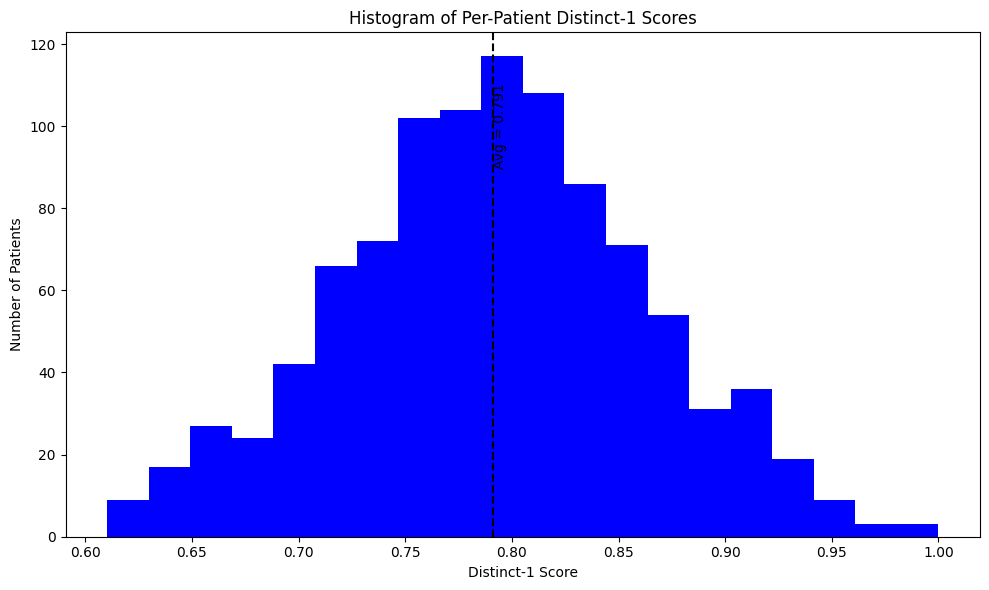

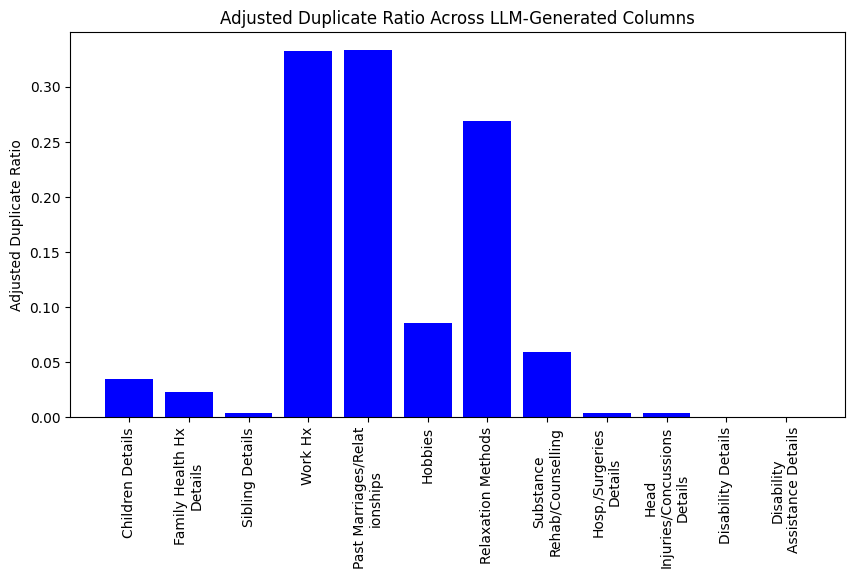

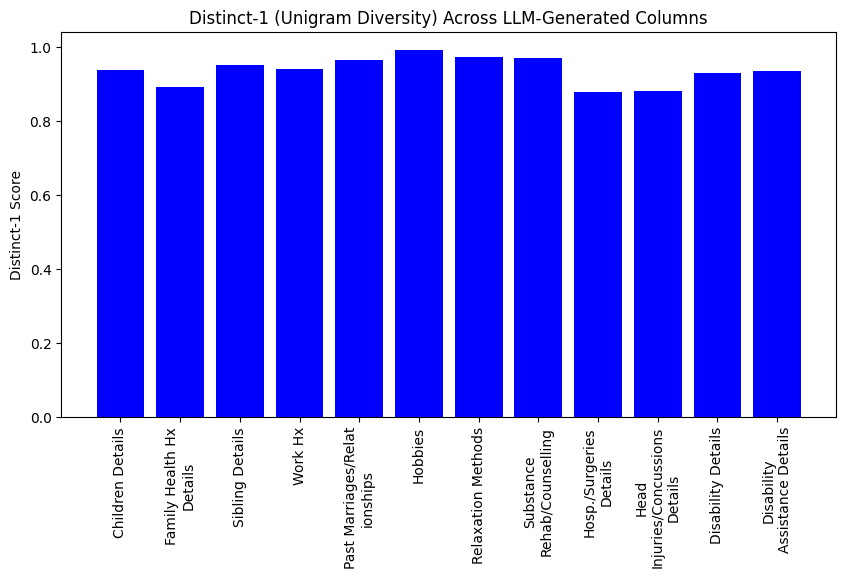

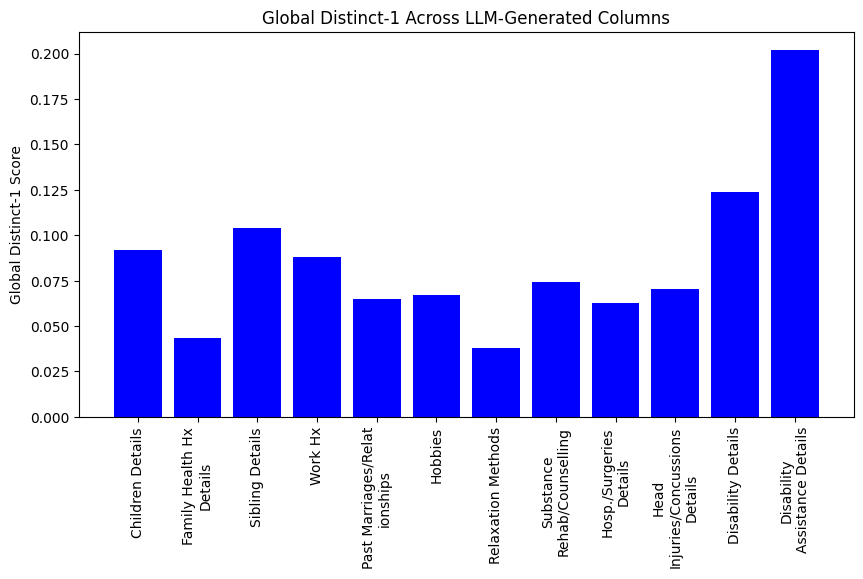

In [4]:
# Recalculate duplicate ratios only for non-empty entries in each LLM-generated column
adjusted_repetition_stats = {}

for col in llm_columns:
    non_empty_entries = df[col].dropna()
    unique_count = non_empty_entries.nunique()
    duplicate_count = len(non_empty_entries) - unique_count  # Total - unique
    adjusted_duplicate_ratio = duplicate_count / len(non_empty_entries) if len(non_empty_entries) > 0 else 0
    distinct_1 = compute_distinct_ngram_ratio(non_empty_entries, n=1)
    global_distinct_1 = compute_global_distinct_n(non_empty_entries, n=1)

    adjusted_repetition_stats[col] = {
        "Total Non-Empty Entries": len(non_empty_entries),
        "Unique Entries": unique_count,
        "Duplicated Entries": duplicate_count,
        "Adjusted Duplicate Ratio": adjusted_duplicate_ratio,
        "Distinct-1 (Unigram Diversity)": distinct_1,
        "Global Distinct-1": global_distinct_1
    }

batch_distinct1 = compute_batch_global_distinct_n(df, llm_columns, n=1)
print(f"Batch Global Distinct-1 (all columns): {batch_distinct1:.3f}")

# Convert to DataFrame for better visualization
adjusted_repetition_df = pd.DataFrame.from_dict(adjusted_repetition_stats, orient='index')

# — compute per-row scores —
scores = df.apply(lambda r: compute_row_distinct1(r, llm_columns), axis=1)

# — overall average —
avg_score = scores.mean()
std_score = scores.std()
print("std: ", std_score)

# — plot histogram —
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, color='blue')                # you can adjust `bins` as desired
plt.xlabel("Distinct-1 Score")
plt.ylabel("Number of Patients")
plt.title("Histogram of Per-Patient Distinct-1 Scores")

# mark the average
plt.axvline(avg_score, linestyle='dashed', color='black')
plt.text(
    avg_score,
    plt.ylim()[1] * 0.9,
    f"Avg = {avg_score:.3f}",
    rotation=90,
    va="top"
)

plt.tight_layout()
filename = "histogram_distinct_1_per_patient.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()


# Bar chart for adjusted duplicate ratio
plot_graphs(llm_columns_abbr, adjusted_repetition_df["Adjusted Duplicate Ratio"], "Adjusted Duplicate Ratio", "Adjusted Duplicate Ratio Across LLM-Generated Columns")

# Bar chart for Distinct-1 (Unigram Diversity)
plot_graphs(llm_columns_abbr, adjusted_repetition_df["Distinct-1 (Unigram Diversity)"], "Distinct-1 Score", "Distinct-1 (Unigram Diversity) Across LLM-Generated Columns")

plot_graphs(llm_columns_abbr, adjusted_repetition_df["Global Distinct-1"], "Global Distinct-1 Score", "Global Distinct-1 Across LLM-Generated Columns")


In [5]:
## bootstrapping
bootstrap_results = bootstrap_sample(df, llm_columns, n_samples=1000)
standard_devs = compute_standard_deviation(bootstrap_results)

# Print results
for col in llm_columns:
    print(f"Column: {col}")
    for metric, std in standard_devs[col].items():
        print(f"  {metric}: {std:.4f}")

Column: Children Details
  dup_ratio: 0.0154
  distinct_1: 0.0076
  global_dis_1: 0.0082
Column: Family History of Health Conditions Details
  dup_ratio: 0.0153
  distinct_1: 0.0098
  global_dis_1: 0.0059
Column: Sibling Details
  dup_ratio: 0.0153
  distinct_1: 0.0068
  global_dis_1: 0.0085
Column: Previous Work History
  dup_ratio: 0.0156
  distinct_1: 0.0075
  global_dis_1: 0.0080
Column: Previous Marriages/Long-Term Relationships
  dup_ratio: 0.0156
  distinct_1: 0.0058
  global_dis_1: 0.0070
Column: Hobbies
  dup_ratio: 0.0155
  distinct_1: 0.0029
  global_dis_1: 0.0071
Column: Relaxation Methods
  dup_ratio: 0.0158
  distinct_1: 0.0051
  global_dis_1: 0.0055
Column: Rehab or Substance Counselling
  dup_ratio: 0.0154
  distinct_1: 0.0052
  global_dis_1: 0.0076
Column: Previous Hospitalizations or Surgeries Details
  dup_ratio: 0.0152
  distinct_1: 0.0103
  global_dis_1: 0.0069
Column: Head Injuries or Concussions Details
  dup_ratio: 0.0152
  distinct_1: 0.0102
  global_dis_1: 0.0

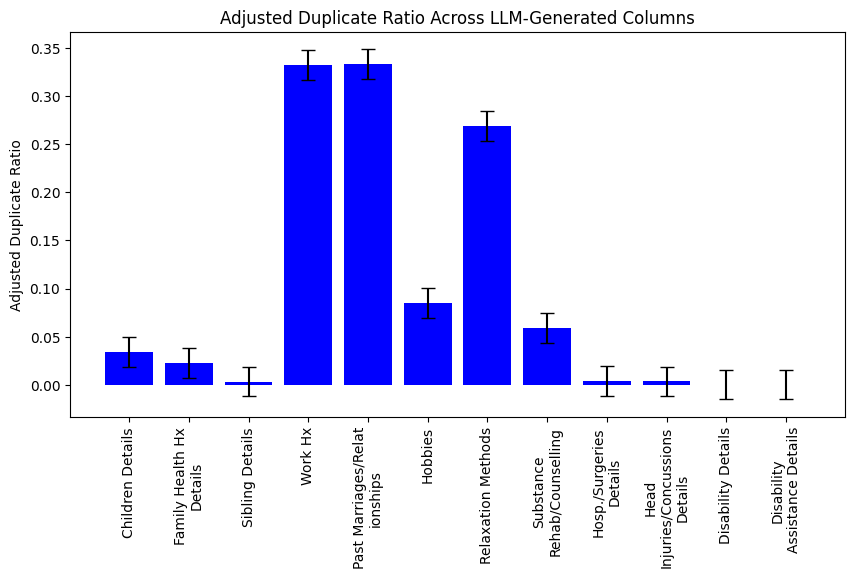

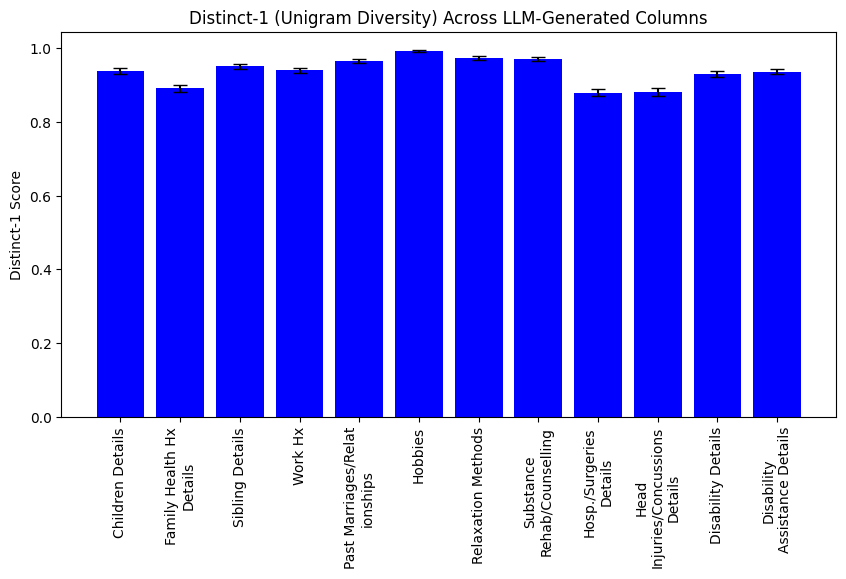

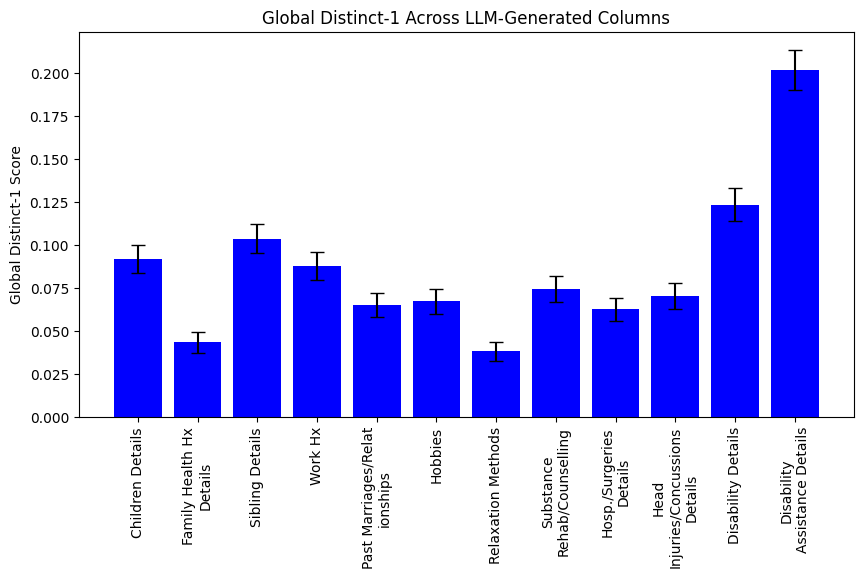

In [6]:
# Extract standard deviations for duplicate ratio
standard_devs_dup = [standard_devs[col]["dup_ratio"] for col in adjusted_repetition_df.index]

# Extract standard deviations for Distinct-1
standard_devs_distinct = [standard_devs[col]["distinct_1"] for col in adjusted_repetition_df.index]

standard_devs_global_dis = [standard_devs[col]["global_dis_1"] for col in adjusted_repetition_df.index]

# Plot Adjusted Duplicate Ratio
plot_graphs_std(
    llm_columns_abbr,
    adjusted_repetition_df["Adjusted Duplicate Ratio"],
    standard_devs_dup,
    "Adjusted Duplicate Ratio",
    "Adjusted Duplicate Ratio Across LLM-Generated Columns"
)

# Plot Distinct-1 (Unigram Diversity)
plot_graphs_std(
    llm_columns_abbr,
    adjusted_repetition_df["Distinct-1 (Unigram Diversity)"],
    standard_devs_distinct,
    "Distinct-1 Score",
    "Distinct-1 (Unigram Diversity) Across LLM-Generated Columns"
)

plot_graphs_std(
    llm_columns_abbr,
    adjusted_repetition_df["Global Distinct-1"],
    standard_devs_global_dis,
    "Global Distinct-1 Score",
    "Global Distinct-1 Across LLM-Generated Columns"
)
